Лабораторная посвящена базе данных, связанной с футбольным командами. Схема расположена на картинке ниже.

## Описание таблиц 
### Coaches - Таблица тренеров 
id - уникальный идентификатор тренера

Name - имя тренера 

### Teams - Таблица команд 
id - уникальный идентификатор  команды 

Name - имя команды 

Location - расположение команды 

Coach_id - идентификатор тренера 

### Players - Таблица игроков 
Id - уникальный идентификатор игрока 

Name - имя игрока 

Position_id - идентификатор позиции 

Age - возраст игрока 

Team_id - идентификатор команды 

Start_date - дата начала игры в команде 


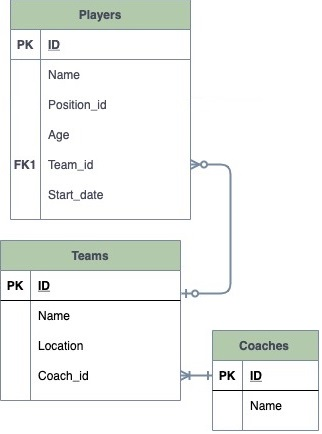

# Задание 1
Реализовать таблицы со связями по схеме выше.

In [ ]:
%reload_ext sql
%sql sqlite:///base.db

'Connected: @base.db'

In [ ]:
%%sql
Pragma foreign_keys=on;

DROP TABLE if exists Coaches;
DROP TABLE if exists Teams;
DROP TABLE if exists Player;

CREATE TABLE  Player (
          team_id     integer NOT NULL , -- создаем внешний ключ
          id          integer NOT NULL Primary key, 
          name        varchar, 
          age         integer,
          position_id integer,
          start_date  integer
          ); 

CREATE TABLE Teams (
          coach_id integer NOT NULL , -- создаем внешний ключ
          id       integer NOT NULL Primary key,
          location varchar,
          name     varchar,
          FOREIGN KEY (id) REFERENCES Player(team_id)); -- указываем какая таблица с какой связана ии каким ключем

CREATE TABLE Coaches (
          id   integer NOT NULL Primary key, 
          name varchar,
          FOREIGN KEY (id) REFERENCES Teams(coach_id));-- указываем какая таблица с какой связана ии каким ключем

 * sqlite:///base.db
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

# Задание 2
Написать функцию, осуществляющую добавление тренера. На вход функции подается имя тренера. При невозможности вставки функция должна обработать данное исключение и вывести пользователю информацию о проблеме

После написания функции необходимо добавить несколько тренеров для таблицы.

In [ ]:
import sqlite3
db = sqlite3.connect('base.db')

In [ ]:
def insert_coaches(name):
    cur = db.cursor()
    cur.execute('SELECT COALESCE(MAX(id)+1, 1) FROM Coaches') # подбираем индекс для тренера
    ID = cur.fetchone()[0] # номер тренера
    cur.execute('''
        INSERT INTO Coaches(id, name) 
        VALUES(?,?)''', (ID,name)) # добавляем в таблицу данные
    db.commit()

In [ ]:
insert_coaches('Sluckiy')
insert_coaches('Kapello')

In [ ]:
%%sql
select * from Coaches;

 * sqlite:///base.db
Done.


id,name
1,Sluckiy
2,Kapello


# Задание 3

Написать функцию, осуществляющую добавление команды. На вход функция принимает (имя команды, местоположение, имя тренера).
На выходе должна быть добавлена команда.

После написания функции необходимо добавить несколько команд.

In [ ]:
def insert_teams(name1, location, name2): # имя игрока, местоположение, имя трененра
    cur = db.cursor()
    cur.execute('SELECT coalesce(MAX(id)+1,1) FROM Teams') # подбираем индекс для команды
    id = cur.fetchone()[0] #номер команды
    cur.execute('SELECT coalesce(id,-1) FROM Coaches WHERE name = ?', (name2, )) # подбираем индекс тренера
    coach_id = cur.fetchone()[0] # номер тренера
    cur.execute('INSERT INTO Teams(id,name, location, coach_id) VALUES(?,?,?,?)', (id, name1, location, coach_id)) # записыавем данные в таблицу
    db.commit() # сохраняем

In [ ]:
insert_teams('Super','Moscow','Sluckiy')
insert_teams('Stare','Tula','Kapello')

In [ ]:
%%sql
select * from Teams;

 * sqlite:///base.db
Done.


coach_id,id,location,name
1,1,Moscow,Super
2,2,Tula,Stare


# Задание 4

Написать функцию, осуществляющую обновление информации о команде. У функции на входе должен быть один обязательный параметр - название команды и два необязательных параметра - имя тренера и местоположение. При этом хотя бы один из необязательных параметров должен быть заполнен. Функция должна обновлять значение переданных необязательных параметров.

После написания функции вызовите данную функцию несколько раз.

In [ ]:
def update_teams(name1,location = 'null' ,name2 = 'null'):
  cur = db.cursor()
  cur.execute('''SELECT id FROM Teams WHERE name = ? ''', (name1,))
  if location == 'null': # смотрим какая из двух необязательных позиций null, если это местоположение
    cur.execute('SELECT id FROM Coaches WHERE name = ?', (name2,)) # определяем id тренера
    coach_id = cur.fetchone()[0] # id тренера
    cur.execute('''UPDATE Teams set coach_id = ? WHERE name = ?''', (coach_id, name1)) # меняем id тренера. опираясь на название команды
  if name2 == 'null':# смотрим какая из двух необязательных позиций null, если это имя
    cur.execute('''UPDATE Teams set location = ? WHERE name = ?''', (location, name1)) # меняем местоположение, опираясь на название команды
  db.commit()

In [ ]:
update_teams('Super',location = 'Tula')
update_teams('Stare', name2 = 'Sluckiy')

In [ ]:
%%sql
select * from Teams;

 * sqlite:///base.db
Done.


coach_id,id,location,name
1,1,Tula,Super
1,2,Tula,Stare


# Задание 5

Написать функцию, осуществляющую добавление нового футболиста в таблицу игроков. На входе (имя, возраст, позиция, название команды, дата перехода в команду(необязательный параметр)). Если дата перехода не указана, то нужно использовать текущую дату. Предусмотреть различные ошибки (такие как неверное имя позиции, неверное название команды (игрока нельзя добавить, если его команды нет в таблице команд), возраст < 0 и т.п.)

После написания функции необходимо добавить несколько игроков.

In [ ]:
from datetime import date
date = str(date.today()) # сегодня

def insert_players(name, age, position, team, start_date = date):
  cur=db.cursor()
  if type(name) == type(145):
    print('Тип имени не верный')
    return 1
  if age >= 100 or age <= 10:
    print('Возраст вводится не верно')
    return 2
  if type(position) == type(145):
    print('Тип местоположения не верный')
    return 3
  if start_date <= '1920-12-12':
    print('Не верная дата')
    return 4
  cur.execute('SELECT coalesce(MAX(id)+1,1) FROM Player') # подбираем индекс для игрока
  id = cur.fetchone()[0] #номер игрока
  cur.execute('SELECT id FROM Teams WHERE name = ?', (team,)) # определяем id команды
  team_id1 = cur.fetchone()[0] # id команды
  cur.execute('INSERT INTO Player(team_id, id, name, age, position_id, start_date) values(?,?,?,?,?,?)', 
              (team_id1, id, name, age, position, start_date)) # записыавем данные в таблицу
  db.commit() # сохраняем


In [ ]:
insert_players(15 , 10, 'Captain', 'Super', '2020-11-17')

Тип имени не верный


1

In [ ]:
insert_players('Dzuba' , 12, 'Captain', 'Super', '2020-11-17')

In [ ]:
insert_players('Dzuba' , 25, 456, 'Super', '2020-11-17')

Тип местоположения не верный


3

In [ ]:
insert_players('Dzuba' , 25, 'Moscow' , 'Super', '1900-11-17')

Не верная дата


4

In [ ]:
insert_players( 'Dzuba', 20, 'Captain', 'Super', start_date = '2020-11-17')
insert_players( 'Arshavin', 27, 'Player', 'Stare', start_date = '2020-11-27')

In [ ]:
%%sql
select * from Player;

 * sqlite:///base.db
Done.


team_id,id,name,age,position_id,start_date
1,1,Dzuba,12,Captain,2020-11-17
1,2,Dzuba,20,Captain,2020-11-17
2,3,Arshavin,27,Player,2020-11-27
